# How to Recommend Movies to Users Based on Ratings

In [106]:
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import os
import scipy.sparse
import warnings
warnings.filterwarnings('ignore')

from kneed import KneeLocator 
from numpy.linalg import norm
from networkx.algorithms import bipartite
from networkx.algorithms.bipartite import from_biadjacency_matrix
from networkx.drawing.layout import bipartite_layout
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

np.set_printoptions(precision=3, linewidth=100)

# MovieLens DataSet

For more information, visit here: https://grouplens.org/datasets/movielens/ (ml-latest-small)

The MovieLens dataset was collected by GroupLens Research and made available from the MovieLens website, with data sets collected over various periods of time
As mentioned before, the smaller version had over 100,000 ratings from 1-5 applied to 9,000 movies by 600 users. Movies are updated as of September 2018, so newer movies are not included here.​ 


In [107]:
data_dir = "/Users/josephchang/Downloads/ml-latest-small"

# Data Cleaning

 This is the movie_data showing each movie index, movie title, and genre. Some genres include adventure, comedy, fantasy, and some movies could have more than one genre.
Here, the first five rows are shown.


In [108]:
movie_data = pd.read_csv(os.path.join(data_dir, "movies.csv"))
movie_data['movieId'] -= 1
movie_data.head()

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,Jumanji (1995),Adventure|Children|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,4,Father of the Bride Part II (1995),Comedy


Next is the rankings data. This shows the first five rows of user index, movie index, rating, and timestamp. In the rating column, it originally showed ratings 1-5, but I cubed each rating to signify a greater attraction towards a movie. 
Additionally, only ratings with a score of 64 or above are included. This removed ratings that were not as high and allowed me to compare movies which I will show later.


In [109]:
ranking = pd.read_csv(os.path.join(data_dir, "ratings.csv"))
ranking['userId'] -= 1
ranking['movieId'] -= 1
ranking['rating']  = np.power((ranking['rating']),3)
ranking = ranking.query('rating >= 64.0')
ranking.head()

,userId,movieId,rating,timestamp
0,0,0,64.0,964982703
1,0,2,64.0,964981247
2,0,5,64.0,964982224
3,0,46,125.0,964983815
4,0,49,125.0,964982931


Once I had a moviedata and a rankings data, I merged them together with the common column of movieId. This new dataset contains userid, movieid, rating, timestamp, title of movie, and genre of movie. 


In [110]:
data = pd.merge(ranking, movie_data, how = "left", on = "movieId")
display(data)

,userId,movieId,rating,timestamp,title,genres
0,0,0,64.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,0,2,64.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,0,5,64.0,964982224,Heat (1995),Action|Crime|Thriller
3,0,46,125.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,0,49,125.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
48575,609,166527,64.0,1493879365,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi
48576,609,166533,64.0,1493848402,Split (2017),Drama|Horror|Thriller
48577,609,168247,125.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
48578,609,168249,125.0,1494273047,Get Out (2017),Horror


# Training / Testing Split

Next, I split the new dataset into training and testing sets. So, I split training and testing at 80% and 20% respectively for each user. Notice that after splitting, there are 487 training users and 122 testing users. This matches our total of 609 users which was before splitting


In [111]:
X_train_users, X_test_users = train_test_split(data['userId'].unique(), train_size=0.8, random_state = 25)

print(f"No. of training users: {X_train_users.shape[0]}")
print(f"No. of testing users: {len(X_test_users)}")

No. of training users: 487
No. of testing users: 122


In [112]:
X_training = data[data['userId'].isin(X_train_users)]
X_testing = data[data['userId'].isin(X_test_users)]

# Training Data Statistics

Next I will generate statistics of the training data. To see how many movies each user watched, notice that the mean is around 80 movies with minimum at 3 and maximum at 1227.

In [113]:
groups = X_training.groupby('userId')['movieId'].count()
groups_df = pd.DataFrame({'userId':groups.index, 'Count':groups.values})

display(groups_df['Count'].describe())

count     487.000000
mean       80.476386
std       111.258028
min         3.000000
25%        21.000000
50%        39.000000
75%        93.000000
max      1227.000000
Name: Count, dtype: float64

As a check, I found user 327 to have watched the most movies at 1227 movies. This user could be a bot or machine that was watching movies continuously and rating it. 


In [114]:
# check the id with largest count
display(groups_df['Count'].loc[groups_df['Count'] == 1227])

327    1227
Name: Count, dtype: int64

Even though this outlier could skew the data, I still decided to keep this user because this would help us understand the dataset better from a larger perspective.
Basically, I wanted to keep as many users as possible even if they bots or machines because they are still part of the observation within the population.


I also plotted a histogram of the distributions to visualize better. The distribution seems to be at a negative exponential graph.


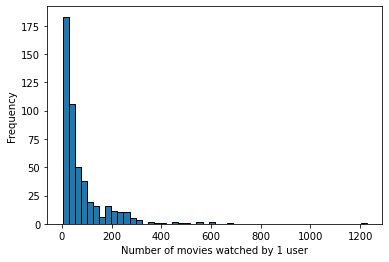

In [115]:
plt.hist(groups_df['Count'].values, bins = 50, edgecolor = 'black')
plt.ylabel('Frequency')
plt.xlabel('Number of movies watched by 1 user');

# Build The graph

Now that I have the total users and total movies, I can visualize which users watched which movies by building a bipartite graph with nodes. A bipartite graph is a set of graph decomposed into two sets, and nodes of one set are connected with nodes from the other set. Generally, the edges or lines signify the link from user to movie.

A sparse matrix is a matrix composed mostly of zeros, with a number signaling the rating a user gave when watching that specific movie.
Since its very hard to display this large matrix, I set W to show user and movie respectively in a tuple, along with the corresponding rating

For simplicity, I will define the following:
W: sparse matrix of rating
G: bipartite graph

In [116]:
users = X_training['userId'].unique()
movies = X_training['movieId'].unique()
print("Number of training users:", len(users))
print("Number of training movies:", len(movies))

Number of training users: 487
Number of training movies: 5861


In [117]:
def build_graph(userId, movieId, rating):
    # assign userid and movieid as a list
    user_names = sorted(set(userId))
    movie_names = sorted(set(movieId))

    num_users = len(user_names)
    num_movies = len(movie_names)
    
    # assign nodes as integers
    users = np.arange(num_users, dtype=int)
    movies = np.arange(num_movies, dtype=int)
    
    # assign list as dictionary. each key is userid, reference is movieid. each tuples first is key, second is reference
    node_of_user = dict(zip(user_names, users))
    node_of_movie = dict(zip(movie_names, movies))

    # row shows all the key values, column shows all the reference values
    row = [node_of_user[user_name] for user_name in userId]
    column = [node_of_movie[movie_name] for movie_name in movieId]
    
    # shows user, movie as tuple and rating as int
    W = scipy.sparse.csr_matrix((rating, (row, column)), shape=(num_users, num_movies))
    G = from_biadjacency_matrix(W)
    
    return G, node_of_user, node_of_movie, W

In [118]:
G, node_of_user, node_of_movie, W = build_graph(X_training['userId'].values, X_training['movieId'].values, X_training['rating'].values)

I can also see the connected components. Here 6348 components are connected together, meaning users are similar to one another

In [119]:
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

[6348]

In [120]:
print("Number of Nodes:", G.number_of_nodes())
print("Number of Edges:", G.number_of_edges())
print("Is graph bipartite?", bipartite.is_bipartite(G))

Number of Nodes: 6348
Number of Edges: 39192
Is graph bipartite? True


In [121]:
def bipartite_layout(G, users, movies, align, reverse: bool = False):
    """Extends networkx's bipartite_layout() to potentially reverse the order of nodes
    within a partiton (up-down or left-right flip depending on the value of 'align'."""
    
    pos = nx.drawing.layout.bipartite_layout(G, users, align=align)
    if reverse:
        pos = dict(
            list(zip(users, [pos[k] for k in users][::-1])) + \
            list(zip(movies, [pos[k] for k in movies][::-1]))
        )
    return pos

In [122]:
def draw_bipartite_graph(G, node_of_user, node_of_movie):
    # length of user, movie list
    num_users = len(node_of_user)
    num_movies = len(node_of_movie)
    
    # assigns list of user and movie as a integers. users are 0-3, movies are 4-8
    users = np.arange(num_users, dtype=int)
    movies = np.arange(num_users, num_users + num_movies, dtype=int)
    
    # Draws the graph.
    pos = bipartite_layout(G, users, movies, align="vertical", reverse=True)

    options = {"edgecolors": "tab:gray", "node_size": 200, "alpha": 0.9}
    nx.draw_networkx_nodes(G, 
                           dict((k, pos[k]) for k in users),
                           nodelist=users, node_color="tab:red", **options)
    nx.draw_networkx_nodes(G, 
                           dict((k, pos[k]) for k in movies),
                           nodelist=movies, node_color="tab:blue", **options)
    nx.draw_networkx_edges(G, pos, width=3, alpha=0.5)

    labels = dict(
        [(index, name) for name, index in node_of_user.items()] + \
        [(index, name) for name, index in node_of_movie.items()]
    )
    nx.draw_networkx_labels(G, pos, labels, font_size=17, font_color="whitesmoke")
    plt.tight_layout()
    plt.axis("off")
    plt.show()

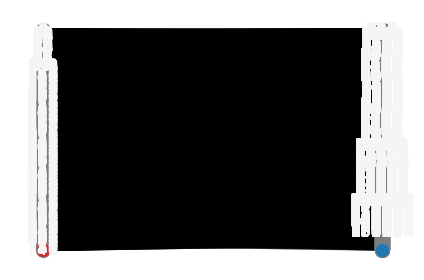

In [123]:
draw_bipartite_graph(G, node_of_user, node_of_movie)


Unfortunately, I could not properly display the graph because the jupyter notebook could not support such a large graph (there are 6000 nodes and 39 thousand edges). So the best visualization is shown here. But there is not too much information to infer from it 


To solve this, I also tried to include only the first 100 users and at a smaller scale, but producing such a graph would not be meaningful because it would not accurately depict the entire population of users.


I also tried to visualize using another software called Gephi. While I was able to somewhat succesfully run in Gephi, there were still too many nodes to clearly see and distinguish users.


# Build Feature Vectors

Overall, the recommender system is composed of three of these next steps: building features, using cosine similarity to get closest nieghbors per user, and clustering together those similar users.
The first step is to build feature vectors. There are 3 matrices involved in this first step, which includes matrix multiplication to derive feature vectors.


First there is a W matrix which has a rows of the user and columns of the movies.
Second, a beta matrix which is the feature vectors for each movie. 
Finally, an alpha matrix which is the feature vectors for each user. 

Each matricies should ideally have these dimensions:

beta: movies * features, 
W: users * movies, 
alpha: users * features

In [124]:
def generate_feature_vectors(W: scipy.sparse.csr_matrix, num_features: int, num_iterations: int):
    num_users, num_movies = W.shape
    users = np.arange(num_users, dtype=int)
    movies = np.arange(num_movies, dtype=int)
    
    np.random.seed(42123)
    # Define alpha as a matrix of user feature vectors. Each row is a user vector.
    alpha = 2 * np.random.rand(num_users, num_features) - 1
    # Normalize rows to unit norm
    alpha = alpha / (np.sum(alpha**2, axis = 1) ** 0.5)[:, None]
    display(alpha)
    # Allocate beta as a matrix of movie feature vectors. Each row is a movie vector.
    beta = np.zeros((num_movies, num_features))

    for i in range(num_iterations):
        beta = np.array((W.T @ alpha) / np.sum(W, axis=0).T)
        # Normalize each vector.
        beta /= (np.sum(beta ** 2, axis = 1) ** 0.5)[:, None]

        alpha = np.array((W @ beta) / np.sum(W, axis=1))
        # Normalize each vector.
        alpha /= (np.sum(alpha ** 2, axis = 1) ** 0.5)[:, None]

    return alpha, beta

In [125]:
num_features = 10
num_iterations = 2

alpha, beta = generate_feature_vectors(W, num_features, num_iterations)

array([[ 0.39 , -0.28 ,  0.171, ...,  0.364, -0.336, -0.276],
       [-0.535, -0.331,  0.184, ...,  0.209,  0.23 ,  0.338],
       [ 0.476,  0.142, -0.177, ...,  0.045,  0.377, -0.305],
       ...,
       [ 0.111, -0.298,  0.515, ...,  0.499,  0.262, -0.345],
       [-0.13 ,  0.049, -0.123, ..., -0.378, -0.331,  0.168],
       [ 0.218, -0.161, -0.557, ...,  0.453, -0.212,  0.068]])

So a feature is a numerical property of a particular user. For the alpha and beta matrix, I decided to use 10 features, which is randomly generated from -1 and 1. Here you can see the starting values for the alpha matrix. This is where I set the ititial values for alpha. 

In [126]:
print(alpha.shape)

(487, 10)


You can see that its dimensions are 487 by 10, where 487 is for each row of user and 10 coumns per feature. Each row is also normalized, meaning the sum of every row is 1. This keeps all of the rows consistent.

### Matrix Multiplication

In the function above, I came up with features with matrix multiplication for each user using an iterative process with the following steps: In the first step, I calculated the beta matrix by multiplying the transpose of W with Alpha, which has set initial values. Originally, W’s dimensions were (Users times Movies). But now since this is transpose, the dimensions are now Movies times users. 

So when I multiply W of T with alpha, this gives us a beta matrix of movie vectors. Then, movies times users mutiplied by users times features gives us movies times features. This here is the beta matrix which has 5861 rows for each movie and 10 columns for each feature

In [127]:
display(beta)
print(beta.shape)

array([[ 0.266,  0.472,  0.171, ..., -0.049, -0.094, -0.039],
       [ 0.334,  0.382,  0.092, ..., -0.157, -0.063,  0.018],
       [ 0.171,  0.3  , -0.017, ..., -0.248, -0.136,  0.09 ],
       ...,
       [-0.072, -0.36 , -0.311, ..., -0.149, -0.45 , -0.486],
       [-0.072, -0.36 , -0.311, ..., -0.149, -0.45 , -0.486],
       [ 0.018,  0.601,  0.319, ..., -0.024, -0.256, -0.039]])

(5861, 10)


Now I want to update our alpha matrix. The reason I want to do this is so alpha is no longer a random vector. Alpha’s vector values will be updated for each user using information from the W matrix. I can update alpha by mutliplying W with our newly defined beta matrix


This corresponds to a W dimension of users times movies multiplied with a beta dimension of movies times features, giving us once again an alpha dimension of users time features. Below the alpha matrix has 487 rows for each user and 10 columns for each feature.

In [128]:
display(alpha)
print(alpha.shape)

array([[ 0.341,  0.548,  0.103, ...,  0.109, -0.203, -0.202],
       [-0.386, -0.092,  0.227, ...,  0.517,  0.143,  0.153],
       [ 0.336,  0.556,  0.178, ...,  0.063, -0.264, -0.268],
       ...,
       [ 0.247,  0.559,  0.109, ...,  0.123, -0.099, -0.221],
       [ 0.281,  0.56 ,  0.206, ..., -0.086, -0.209, -0.048],
       [ 0.235,  0.521, -0.075, ...,  0.168, -0.221, -0.171]])

(487, 10)


# Investigate Properties of Random Walk

In [129]:
alpha_df = pd.DataFrame(alpha)
alpha_df = alpha_df.rename(columns=lambda x: x+ 1)
alpha_df = alpha_df.set_index(X_training['userId'].unique(), drop=False).rename_axis(None)

beta_df = pd.DataFrame(beta)
beta_df = beta_df.rename(columns=lambda x: x + 1)
beta_df = beta_df.set_index(X_training['movieId'].unique(), drop=False).rename_axis(None)

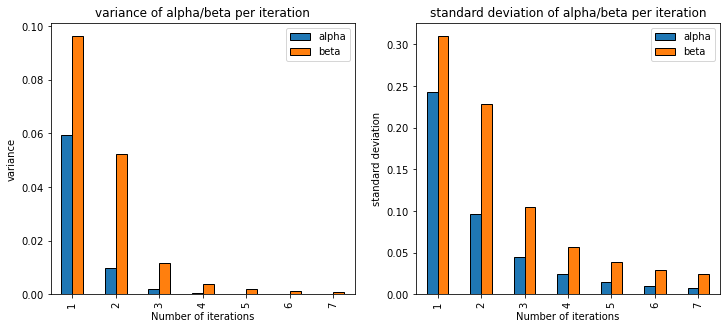

In [131]:
# Bar graphs of alpha and beta variance and standard deviations vs. # iterations.
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
num_types = 2

bar_labels = [str(i+1) for i in range(len(features))]
transforms = (np.var, np.std)
transform_labels = ('variance', 'standard deviation')

for transform, ax, transform_label in zip(transforms, axs, transform_labels):
    feature_values = [[np.mean(transform(feature[i], axis=0)) for feature in features]
                      for i in range(num_types)]
    plotdata = pd.DataFrame({"alpha": feature_values[0], "beta": feature_values[1]}, index=bar_labels)
    plotdata.plot(kind = "bar", edgecolor = "black", ax=ax)

    ax.set_title(f'{transform_label} of alpha/beta per iteration')    
    ax.set_xlabel('Number of iterations')
    ax.set_ylabel(f'{transform_label}');

From the bar plot, variance for both alpha and beta decreased over increased iterations. With more iterations, the features will converge because the features are learning more and more about which users are similar to other users hence the change in numbers.

I need to limit iterations or else the users then will become so similar that I won’t be able to differentiable any of them. In otherwords, I dont want alpha features to converge because otherwise I lose information about what makes each user unique. 

From the graph, it appears for alpha, there is huge drop off at the second iteration. As a result, I will choose to set the number of iterations at 2 because that is the least amount of visible variance. That is why in the previous section the number of iterations is set at 2 when building feature vectors with alpha/beta.


# Calculate User Similarity

Now going to step 2, which is calculating user similarity, or each users' closest neighbor. I am going to use features from the alpha matrix to come up with a similarity index. I will use cosine similarity to determine the closest distance of every user. 


Cosine similarity measures the cosine of the angle between two vectors and determines how much the two vectors are similar. This is the matrix of cosine similarity for each user. As you can see, the 0.00 represents distance to itself meaning there is no distance.

In [132]:
# calculate cosine distance in dataframe
cosine_df = 1-pd.DataFrame(cosine_similarity(alpha))
display(cosine_df)

,0,1,2,3,4,5,6,7,8,9,...,477,478,479,480,481,482,483,484,485,486
0,0.000000,1.046449,0.029192,0.049678,0.227659,0.068352,0.019818,0.054576,0.119532,0.014339,...,0.034463,0.054588,0.093999,0.149135,0.064104,1.250356e-01,2.960138e-02,1.687099e-02,6.039497e-02,0.054235
1,1.046449,0.000000,1.139650,0.981120,0.909858,0.996987,0.934154,0.986184,0.938079,1.079488,...,1.040307,0.985171,1.147665,0.926858,0.890652,8.267555e-01,9.588006e-01,1.023787e+00,1.059975e+00,1.132563
2,0.029192,1.139650,0.000000,0.083609,0.307385,0.133441,0.054430,0.125334,0.163714,0.053089,...,0.093029,0.106648,0.034429,0.210677,0.149186,1.255342e-01,7.140358e-02,6.203736e-02,1.095677e-01,0.113671
3,0.049678,0.981120,0.083609,0.000000,0.085507,0.014450,0.037760,0.018543,0.031504,0.057314,...,0.061839,0.005444,0.113734,0.038786,0.048843,1.581068e-01,3.203774e-02,8.073928e-02,1.785042e-02,0.134321
4,0.227659,0.909858,0.307385,0.085507,0.000000,0.058022,0.188192,0.072366,0.058596,0.213826,...,0.202465,0.070341,0.320698,0.015934,0.125704,3.399343e-01,1.403764e-01,2.660960e-01,9.811542e-02,0.318814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,0.125036,0.826756,0.125534,0.158107,0.339934,0.218223,0.067152,0.195344,0.187657,0.165200,...,0.168036,0.194662,0.184409,0.276556,0.234027,-2.220446e-16,1.234822e-01,1.517956e-01,2.142208e-01,0.215493
483,0.029601,0.958801,0.071404,0.032038,0.140376,0.043145,0.020006,0.029316,0.053055,0.034893,...,0.069214,0.033774,0.138547,0.080259,0.063157,1.234822e-01,1.110223e-16,6.256445e-02,6.236485e-02,0.115190
484,0.016871,1.023787,0.062037,0.080739,0.266096,0.091535,0.046230,0.069860,0.174314,0.011879,...,0.015299,0.079721,0.147243,0.181918,0.056218,1.517956e-01,6.256445e-02,-2.220446e-16,7.585639e-02,0.039982
485,0.060395,1.059975,0.109568,0.017850,0.098115,0.011000,0.065242,0.021663,0.059856,0.060374,...,0.052141,0.010285,0.154397,0.054381,0.044418,2.142208e-01,6.236485e-02,7.585639e-02,-2.220446e-16,0.116950


In [133]:
closest_indexes = pd.DataFrame(cosine_df.columns.values[np.argsort(cosine_df.values, axis = 1)[:, :4]], 
            index=cosine_df.index, 
            columns = ['Closest index', '2nd index', '3rd index', '4th index']).reset_index()
c = ['Closest index', '2nd index', '3rd index', '4th index']
closest_distance = cosine_df.apply(lambda x: pd.Series(x.nsmallest(4).values, index = c), axis = 1)
display(closest_indexes)
display(closest_distance)

,index,Closest index,2nd index,3rd index,4th index
0,0,0,58,148,435
1,1,1,120,75,279
2,2,2,323,401,87
3,3,3,94,348,292
4,4,4,360,480,465
...,...,...,...,...,...
482,482,482,306,62,40
483,483,483,98,32,196
484,484,484,411,461,135
485,485,485,221,310,141


,Closest index,2nd index,3rd index,4th index
0,0.000000e+00,0.002848,0.003322,0.004326
1,0.000000e+00,0.664554,0.677063,0.709256
2,0.000000e+00,0.004243,0.004858,0.005304
3,0.000000e+00,0.002494,0.002537,0.003242
4,0.000000e+00,0.013429,0.015934,0.016104
...,...,...,...,...
482,-2.220446e-16,0.044287,0.044953,0.046822
483,1.110223e-16,0.012000,0.012334,0.012709
484,-2.220446e-16,0.003885,0.005952,0.006448
485,-2.220446e-16,0.008854,0.008856,0.009792


In [134]:
cosine_df.loc[0, :].nsmallest(4)

0      0.000000
58     0.002848
148    0.003322
435    0.004326
Name: 0, dtype: float64

Next I want to find the closest index for each user as determined by the cosine similarity matrix. On top shows the distance by the closest, 2nd-closest, 3rd, 4th index. Below that shows what index the closest neighbor was. As a check, I will use the 0th user and make sure distance and index match up, which they do


# Clustering

Now that I have users and their closest neighbors, the third step is to cluster together similar users. But I need to find out how many clusters to generate. So, I can use the kneelocator from the kneed package that will show a vertical line, or k, which is the optimal number of clusters.


Kneelocator uses silhouette scores which measure the goodness of a clustering technique. Here I generated the silhouette score from 2 to 20 clusters. Each cluster is shown on the x-axis and on the y-axis, the silhouette score is matched appropriately. 

In [28]:
def kneelocator(matrix):
    sil_avg = []
    range_n_clusters = np.arange(2,20)
    for k in range_n_clusters:
        kmeans = KMeans(n_clusters = k).fit(matrix)
        labels = kmeans.labels_
        sil_avg.append(silhouette_score(matrix, labels, metric = "euclidean"))
        
    kn = KneeLocator(range_n_clusters, sil_avg , curve='convex', direction='decreasing')
    plt.plot(range_n_clusters, sil_avg, 'bx-')
    plt.title('Silhouette analysis for optimal k')
    plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    plt.xticks(np.arange(1, 20, 1))
    plt.xlabel("# of Clusters")
    plt.ylabel('Siloutte Score')
    plt.show()

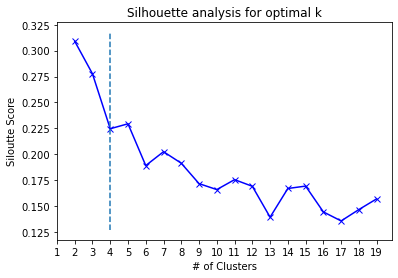

In [29]:
kneelocator(alpha)

From the score, the optimal value is at 4 clusters. So, I will assign the 4 clusters to each user using kmeans which is measuring how many of the users belong in each cluster, which is calculated based on each cluster's center, meaning the cluster’s center is determined and users who are closest to a one of the 4 cluster centers is classified in that cluster

In [86]:
def find_cluster(matrix, num_clusters):
    kmeans = KMeans(n_clusters= num_clusters, init = 'k-means++', random_state = 55).fit(matrix)
    print(np.array(kmeans.labels_))
    alpha_df['clusters'] = kmeans.labels_
    print(alpha_df['clusters'].value_counts())
    return kmeans

In [87]:
# assign each training user to one of the 4 clusters
kmeans = find_cluster(alpha, 4)
kmeans

[3 0 1 0 0 0 3 0 0 3 0 2 1 3 3 3 3 2 3 1 2 0 3 2 0 0 1 0 1 0 0 3 3 0 3 3 0 2 3 2 1 1 2 0 3 0 1 0 1
 3 3 2 3 3 2 3 2 2 3 1 0 2 1 3 3 2 1 2 0 2 3 1 2 1 3 1 1 1 2 0 0 3 3 3 2 0 0 1 0 3 3 1 0 3 0 1 2 1
 3 0 0 3 2 3 3 1 1 2 0 1 3 3 0 1 1 3 2 0 2 3 0 0 2 3 0 1 3 2 1 3 2 3 3 3 3 3 1 0 0 3 3 0 0 0 0 2 3
 0 3 1 3 1 3 3 1 1 1 0 3 1 2 3 1 2 1 2 3 2 0 3 2 2 2 3 3 1 1 1 3 1 3 3 3 2 3 0 2 3 3 3 1 1 3 0 1 0
 3 1 2 2 3 3 2 3 3 2 3 2 2 1 0 3 0 3 1 3 1 0 0 1 2 0 1 0 0 1 3 0 1 3 3 1 2 3 1 3 1 3 0 3 0 3 2 3 1
 1 3 0 1 3 3 2 2 2 0 3 3 1 1 2 3 3 2 1 3 1 0 2 3 2 1 0 3 2 0 3 3 3 3 0 3 1 2 3 2 2 3 1 3 3 3 3 0 0
 3 3 1 0 3 2 2 3 1 0 1 0 3 1 3 2 0 0 3 3 3 2 0 3 0 3 0 2 2 1 0 1 2 3 1 1 3 3 3 1 1 3 3 0 3 1 3 3 2
 1 3 3 2 3 0 0 1 3 3 0 3 3 1 0 0 3 0 2 2 3 1 2 0 1 0 2 3 3 0 3 1 3 1 2 2 0 3 3 3 2 0 3 3 2 1 3 0 1
 3 0 1 1 3 3 2 0 2 1 2 0 3 2 3 2 3 2 0 3 2 3 3 2 0 0 3 3 1 0 2 0 2 3 0 3 2 0 1 1 3 2 2 3 3 3 2 0 3
 0 3 3 2 2 0 0 1 1 0 3 1 1 2 0 3 1 1 2 0 3 2 2 0 0 3 2 1 3 1 3 0 1 3 1 3 2 0 1 0 0 1 3 3 0 3]
3    178
0    1

KMeans(n_clusters=4, random_state=55)

Here we can see most users belong in cluster 3.

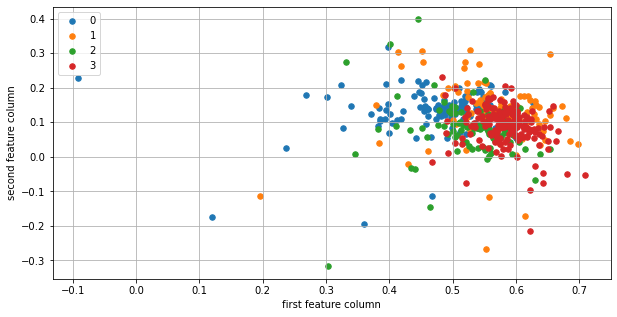

In [88]:
fig, axs = plt.subplots(figsize=(10, 5))
for k, d in alpha_df.groupby('clusters'):
    axs.scatter(d.iloc[:, 1], d.iloc[:, 2], label = k, s = 30)
axs.grid(True)
plt.legend(loc = 2)
plt.xlabel('first feature column')
plt.ylabel('second feature column')
plt.show()

To visualize the clusters assigned, I will plot each user in a scatterplot. I defined the x-axis as the first column of the alpha matrix (which is the 1st feature) and the y-axis as the second column (which is the 2nd feature). I chose to do so with the 1st and 2nd features because I couldnt plot all 10 features.


From the scatterplot, it appears the clustering is somewhat accurate and consistent. The users in red seem to be together with other reds. The same for green. Blues seems to be on the lower values in the first feature, and orange is less consistent.

# Testing/Validation Data

Going back to the training and testing split, I will now use the testing data. I will repeat the process from the training data but now use it on the testing data. For consistency, I again set number of features as 10 and number of iterations as 2, and converted matrices into dataframes appropriately.


Once I have a matrix of testing users, I can recommend for a random user, such as user 9 of the testing set. But first I need to detmerine which cluster user 9 is in. So I will repeat the steps before by using kmeans and assigning into 4 clusters. I will see that user 9 is in cluster 3. As such, I'll filter from the testing set to find all users belonging in cluster 3.


In [89]:
G, node_of_user, node_of_movie, W_test = build_graph(X_testing['userId'].values, X_testing['movieId'].values, X_testing['rating'].values)
num_features = 10 
num_iterations = 2
alpha_test, beta_test = generate_feature_vectors(W_test, num_features, num_iterations)

array([[ 0.39 , -0.28 ,  0.171, ...,  0.364, -0.336, -0.276],
       [-0.535, -0.331,  0.184, ...,  0.209,  0.23 ,  0.338],
       [ 0.476,  0.142, -0.177, ...,  0.045,  0.377, -0.305],
       ...,
       [-0.158, -0.306, -0.17 , ...,  0.284, -0.319,  0.375],
       [-0.199, -0.45 ,  0.145, ...,  0.483,  0.23 ,  0.384],
       [ 0.385, -0.176, -0.024, ..., -0.383, -0.463, -0.29 ]])

In [90]:
# convert to a dataframe
alpha_df_test = pd.DataFrame(alpha_test)
alpha_df_test = alpha_df_test.rename(columns=lambda x: x+ 1)
alpha_df_test = alpha_df_test.set_index(X_testing['userId'].unique(), drop=False).rename_axis(None)
alpha_df_test

,1,2,3,4,5,6,7,8,9,10
1,0.089913,0.057992,0.789298,-0.292353,-0.118204,0.001816,-0.453094,0.211980,-0.123935,-0.022938
6,-0.293781,0.125239,0.571495,-0.512533,0.136742,0.153983,-0.217606,0.283472,0.170727,0.330826
9,0.355301,0.305709,0.497688,-0.137773,0.084363,0.397130,-0.427989,0.283570,0.274103,-0.100396
23,-0.235739,0.271507,0.649755,-0.461580,0.101755,0.093597,-0.242534,0.181787,0.137121,0.325096
26,-0.481435,-0.014447,0.428063,-0.533069,0.168779,0.188033,-0.155406,0.163137,0.108874,0.417314
...,...,...,...,...,...,...,...,...,...,...
588,-0.487735,0.251685,0.296637,-0.508418,0.136554,0.193173,-0.061339,0.394462,0.101378,0.355927
591,-0.487485,0.193705,0.435799,-0.498657,0.025277,0.272273,-0.194233,0.250957,0.119974,0.310461
592,-0.348315,0.142318,0.543307,-0.485701,0.144147,0.100630,-0.186776,0.287190,0.183031,0.381530
596,-0.458453,-0.080531,0.457871,-0.378874,0.068085,0.118362,-0.172764,0.302461,0.266692,0.468022


## Test on a random user

In [91]:
def find_clusters_test(matrix):
    kmeans = KMeans(n_clusters=4, init = 'k-means++', random_state = 0).fit(matrix)
    clusters = kmeans.predict(matrix)
    alpha_df_test['clusters'] = clusters
    print(alpha_df_test['clusters'].value_counts())
    display(alpha_df_test)
find_clusters_test(alpha_test)

0    60
1    23
3    22
2    17
Name: clusters, dtype: int64


,1,2,3,4,5,6,7,8,9,10,clusters
1,0.089913,0.057992,0.789298,-0.292353,-0.118204,0.001816,-0.453094,0.211980,-0.123935,-0.022938,3
6,-0.293781,0.125239,0.571495,-0.512533,0.136742,0.153983,-0.217606,0.283472,0.170727,0.330826,0
9,0.355301,0.305709,0.497688,-0.137773,0.084363,0.397130,-0.427989,0.283570,0.274103,-0.100396,3
23,-0.235739,0.271507,0.649755,-0.461580,0.101755,0.093597,-0.242534,0.181787,0.137121,0.325096,0
26,-0.481435,-0.014447,0.428063,-0.533069,0.168779,0.188033,-0.155406,0.163137,0.108874,0.417314,2
...,...,...,...,...,...,...,...,...,...,...,...
588,-0.487735,0.251685,0.296637,-0.508418,0.136554,0.193173,-0.061339,0.394462,0.101378,0.355927,1
591,-0.487485,0.193705,0.435799,-0.498657,0.025277,0.272273,-0.194233,0.250957,0.119974,0.310461,1
592,-0.348315,0.142318,0.543307,-0.485701,0.144147,0.100630,-0.186776,0.287190,0.183031,0.381530,0
596,-0.458453,-0.080531,0.457871,-0.378874,0.068085,0.118362,-0.172764,0.302461,0.266692,0.468022,2


In [92]:
#### Look a cluster 3 of the training set
alpha_df_test_user_row = alpha_df_test.loc[9]
alpha_df_test_user_cluster = int(alpha_df_test.loc[[9], ['clusters']].values)

# training users who belong in the cluster
alpha_df_cluster = alpha_df[alpha_df['clusters'] == alpha_df_test_user_cluster]
alpha_df_cluster

,1,2,3,4,5,6,7,8,9,10,clusters
0,0.340625,0.548322,0.103323,-0.008999,-0.546314,-0.267611,0.329493,0.109062,-0.203432,-0.201598,3
8,0.264884,0.593854,0.092224,-0.127431,-0.567245,-0.297217,0.237267,0.087116,-0.248768,-0.128663,3
12,0.311043,0.562599,0.070191,0.024588,-0.576193,-0.268099,0.372784,0.039920,-0.072080,-0.177682,3
16,0.281619,0.596597,0.106974,0.003517,-0.548977,-0.281156,0.319960,0.074203,-0.190717,-0.169202,3
17,0.183439,0.617568,0.115185,0.035073,-0.519069,-0.289915,0.359618,0.028935,-0.198583,-0.217670,3
...,...,...,...,...,...,...,...,...,...,...,...
595,0.415701,0.466409,-0.014443,-0.014384,-0.438851,-0.443435,0.371528,0.028199,-0.199468,-0.203468,3
599,0.294687,0.580448,0.130761,-0.028222,-0.567071,-0.275816,0.234759,0.129242,-0.181110,-0.236820,3
606,0.337611,0.572400,0.043866,-0.207721,-0.523702,-0.290893,0.343728,0.063070,-0.142689,-0.109254,3
607,0.247246,0.558516,0.108631,0.095183,-0.571474,-0.311225,0.330140,0.123301,-0.098851,-0.220588,3


In [93]:
# append row of user 9
alpha_df_cluster_with_testing_user = alpha_df_cluster.append(alpha_df_test_user_row)
alpha_df_cluster_with_testing_user

,1,2,3,4,5,6,7,8,9,10,clusters
0,0.340625,0.548322,0.103323,-0.008999,-0.546314,-0.267611,0.329493,0.109062,-0.203432,-0.201598,3.0
8,0.264884,0.593854,0.092224,-0.127431,-0.567245,-0.297217,0.237267,0.087116,-0.248768,-0.128663,3.0
12,0.311043,0.562599,0.070191,0.024588,-0.576193,-0.268099,0.372784,0.039920,-0.072080,-0.177682,3.0
16,0.281619,0.596597,0.106974,0.003517,-0.548977,-0.281156,0.319960,0.074203,-0.190717,-0.169202,3.0
17,0.183439,0.617568,0.115185,0.035073,-0.519069,-0.289915,0.359618,0.028935,-0.198583,-0.217670,3.0
...,...,...,...,...,...,...,...,...,...,...,...
599,0.294687,0.580448,0.130761,-0.028222,-0.567071,-0.275816,0.234759,0.129242,-0.181110,-0.236820,3.0
606,0.337611,0.572400,0.043866,-0.207721,-0.523702,-0.290893,0.343728,0.063070,-0.142689,-0.109254,3.0
607,0.247246,0.558516,0.108631,0.095183,-0.571474,-0.311225,0.330140,0.123301,-0.098851,-0.220588,3.0
609,0.234931,0.521444,-0.075309,0.212589,-0.498849,-0.315893,0.408917,0.167694,-0.220902,-0.171076,3.0


Once I have a matrix of only testing users in cluster 3, I also need to find all users in the same cluster 3 for the training set. Then, I can add the row of the testing user 9 into the same dataframe. I basically will combine user 9's row with the all of training users in cluster 3. Now theres a dataframe of many training users and 1 single testing user. 


In [94]:
# Find 5 closest training users to user 9
eu_dist_testing = pd.DataFrame(squareform(pdist(alpha_df_cluster_with_testing_user.iloc[:,:10])), 
                    columns = alpha_df_cluster_with_testing_user.index, index = alpha_df_cluster_with_testing_user.index)

In [95]:
# find 5 closest training user index from the cosine distance matrix
closest_testing_indexes = pd.DataFrame(eu_dist_testing.columns.values[
    np.argsort(eu_dist_testing.values, axis = 1)[:, :2]], 
            index=eu_dist_testing.index, 
            columns = ['Closest user', '2nd user']).reset_index()

In [96]:
c = ['Closest user', '2nd user']
closest_testing_distances = eu_dist_testing.apply(lambda x: pd.Series(x.nsmallest(2).index, index = c), axis = 1)

# show for user 9
closest_testing_distances

,Closest user,2nd user
0,0,68
8,8,487
12,12,590
16,16,402
17,17,102
...,...,...
599,599,94
606,606,114
607,607,521
609,609,355


The reason this is done is so it gives the ability to find the 5 most similiar users to user 9 using the smallest euclidean distance. For those similar users, I'll determine the closest distance and index, as done previously. Of those 5 closest neighbors, I'll create an array of the movies watched by those neighbors. The common movies watched by both will be the movies recommended for user 9

In [97]:
# find the movies of the closest users
closest_users_to_testing_user = list(closest_testing_distances.loc[9, closest_testing_distances.columns != 'Closest user'])
closest_users_to_testing_user_movies = X_training[X_training['userId'].isin(closest_users_to_testing_user)]['movieId'].values 
closest_users_to_testing_user_movies

array([ 222,  592,  596,  661, 1072, 1096, 1221, 1258, 1720, 1922, 1967, 2027, 2296, 2567, 2986,
       3185, 3273, 3284, 3533, 3823, 3824, 3830, 4061, 4158, 4305, 4307, 4885, 4992, 5063, 5064,
       5126, 5151, 5170, 5265, 5328, 5386, 5418, 5419])

In [98]:
# define user 9's movies
user = 9
testing_user_movies = X_testing[X_testing['userId'] ==  user]['movieId'].values
np.array(testing_user_movies)

array([   587,    911,   1906,   3577,   4305,   4446,   4992,   4994,   5951,   6534,   6941,
         7148,   7152,   7153,   7168,   7374,   7457,   8532,   8868,  31684,  33793,  40818,
        49271,  49285,  51704,  58558,  63991,  68953,  69405,  71578,  79090,  81844,  88162,
        91528,  92258,  94069,  95166,  95448,  96078, 103334, 103338, 104373, 106695, 109852,
       112005, 113274, 113393, 136019, 137594, 140109])

In [99]:
# intersection of movies with user9
common_movies_with_testing_user = set(testing_user_movies).intersection(closest_users_to_testing_user_movies)
print(sorted(common_movies_with_testing_user))

[4305, 4992]


Using this same process, I've created a function that summarizes the process above. This function will return a list of recommended movies given the input of a user number.


In [100]:
movies_for_testing_user = list(X_training[X_training['movieId'].isin(common_movies_with_testing_user)]['title'].unique())
movies_for_testing_user

['Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Shrek (2001)']

## Recommend The Movie

Note that this only works for users from the testing data. If a training user is inputted, the function will ask for a different user.
Also, if recommendation is made more than once, so like if I made recommendations for 9 and now I make recommendations for 23 (and both 9 and 23 are in the testing set), user 9 stays in the testing set when I make the recommendation for user 23. User 9 will not go in the training set.


In [101]:
def recommend_movie(user : int):
    if user in alpha_df_test.index:
        # define the selected users row in alpha_df_test and cluster number
        alpha_df_test_user_row = alpha_df_test.loc[user]
        alpha_df_test_user_cluster = int(alpha_df_test.loc[[user], ['clusters']].values)

        # filter alpha_df_test to only have the selected user's cluster
        alpha_df_cluster = alpha_df[alpha_df['clusters'] == alpha_df_test_user_cluster]

        # append row of selected user and update new dataframe with selected user as alpha_df_cluster_with_testing_user
        alpha_df_cluster_with_testing_user = alpha_df_cluster.append(alpha_df_test_user_row)

        # Find 5 closest training users to selected user 
        eu_dist_testing = pd.DataFrame(squareform(pdist(alpha_df_cluster_with_testing_user)), 
                        columns = alpha_df_cluster_with_testing_user.index, index = alpha_df_cluster_with_testing_user.index)

        c = ['Closest user', '2nd user', '3rd user', '4th user', '5th user', '6th']
        closest_testing_distances = eu_dist_testing.apply(lambda x: pd.Series(x.nsmallest(6).index, index = c), axis = 1)

        # find the movies of the closest users
        closest_users_to_testing_user = list(closest_testing_distances.loc[user, closest_testing_distances.columns != 'Closest user'])
        closest_users_to_testing_user_movies = X_training[X_training['userId'].isin(closest_users_to_testing_user)]['movieId'].values
        
        # define selected user's movies
        testing_user_movies = X_testing[X_testing['userId'] ==  user]['movieId'].values
        common_movies_with_testing_user = set(testing_user_movies).intersection(closest_users_to_testing_user_movies)

        # find the intersection of movies watched by selected user and closest user
        movies_for_testing_user = list(X_training[X_training['movieId'].isin(common_movies_with_testing_user)]['title'].unique())
        print(movies_for_testing_user)
        
    else:
        # if user is not from testing data
        print("User Not Found in Testing")

In [104]:
recommend_movie(23)

['Forrest Gump (1994)', 'Fargo (1996)', 'Shawshank Redemption, The (1994)']


In [102]:
recommend_movie(8)

User Not Found in Testing


# Bonus: Jaccard Index

A Jaccard Index can be used to find the similarity between user 9's movies and closest user's movies. The higher the score, the more similiar.

In [105]:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

jaccard(testing_user_movies, closest_users_to_testing_user_movies)

0.023255813953488372